#### Интеллектуальные технологии информационной безопасности. Практическая работа №8
|   Группа          |   ФИО             |   
|   :------------:  |   :------------:  |
|   М092501(71)     |   Шарибжанов И.Т. |

**Цель работы:**
Изучить и реализовать на практике метод сопряженных градиентов для оптимизации весов нейронной сети. В ходе работы необходимо заменить стандартный оптимизатор Keras на собственную реализацию одного из градиентных методов для обучения модели бинарной классификации текстовых данных.

#### 1. Подготовка среды

На этом этапе мы настраиваем окружение (используем TensorFlow/Keras и NumPy), загружаем и предобрабатываем набор данных IMDB, а также создаем архитектуру нейронной сети в соответствии с описанием из книги Франсуа Шолле

Набор данных IMDB содержит 50 000 отзывов (25 000 для обучения, 25 000 для теста), каждый отзыв представлен как последовательность индексов слов (топ-10 000 самых частых слов). Мы векторизуем данные в бинарные векторы (one-hot encoding), где каждый отзыв становится вектором длиной 10 000 с 1 в позициях встречающихся слов.

Модель: полносвязная сеть с двумя скрытыми слоями по 16 нейронов (ReLU активация) и выходным слоем с 1 нейроном (sigmoid для бинарной классификации).

In [ ]:
%pip install tensorflow matplotlib numpy pandas

In [73]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb

# # Установка seed для воспроизводимости
# np.random.seed(42)
# tf.random.set_seed(42)

# Загрузка данных IMDB (топ-10 000 слов)
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)

# Датафрейм с первыми 5 отзывами и метками
df = pd.DataFrame({
    'review': train_data[:5],
    'label': train_labels[:5]
})

print("Топ 5 отзывов с IMDB и их метки:")
print(df.to_string())

# Функция для векторизации последовательностей в бинарные векторы (one-hot)
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype='float32')
    for i, sequence in enumerate(sequences):
        for j in sequence:
            if j < dimension:
                results[i, j] = 1.
    return results

# Векторизация данных
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Преобразование меток в float32
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Создание валидационной выборки (первые 10 000 из обучающих данных)
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

# Подготовка датасетов для батчей
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((partial_x_train, partial_y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Архитектура модели
def build_model():
    model = keras.Sequential([
        layers.Dense(16, activation='relu', input_shape=(num_words,)),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

print("Данные и модель подготовлены.")

Топ 5 отзывов с IMDB и их метки:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review  label
0                 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, ...]      1
1          [1, 194, 1153, 194, 8255, 78

#### 2. Обучение базовой модели

Обучаем модель с использованием стандартного оптимизатора `rmsprop`, функцией потерь `binary_crossentropy` и метрикой `accuracy`. Обучаем на 20 эпохах с батч-размером 512. Фиксируем метрики (loss и accuracy) для baseline. Строим графики потерь и точности.

c:\Users\shari\YandexDisk\МТУСИ_МАГ_М092501(71)\1 семестр\Интеллектуальные технологии информационной безопасности\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7627 - loss: 0.5601 - val_accuracy: 0.8578 - val_loss: 0.4496
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8885 - loss: 0.3693 - val_accuracy: 0.8555 - val_loss: 0.3850
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9172 - loss: 0.2692 - val_accuracy: 0.8879 - val_loss: 0.2987
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9310 - loss: 0.2155 - val_accuracy: 0.8888 - val_loss: 0.2861
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9437 - loss: 0.1783 - val_accuracy: 0.8881 - val_loss: 0.2788
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9542 - loss: 0.1497 - val_accuracy: 0.8802 - val_loss: 0.2931
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9630 - loss: 0.1260 - val_accuracy: 0.8757 - val_loss: 0.3364
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9679 - loss: 0.1080 - val_accuracy: 0.8863 - v

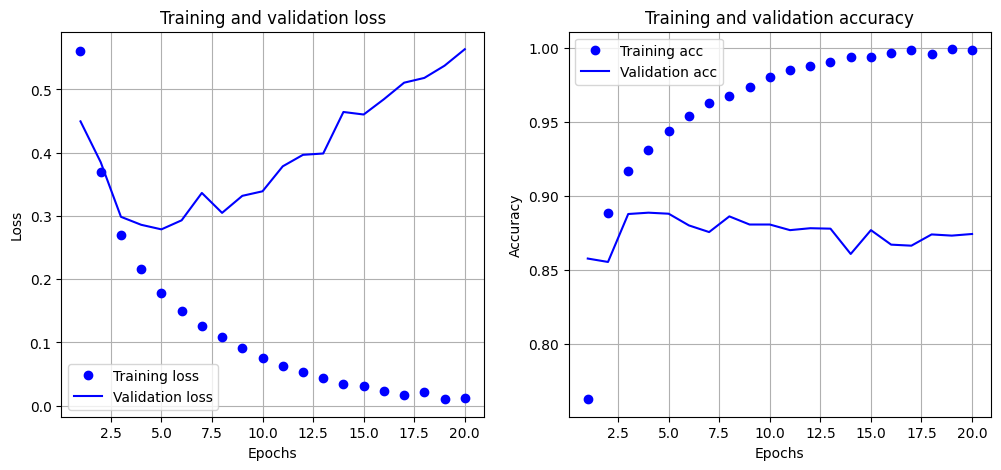

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8614 - loss: 0.6008
Тестовая потеря и точность: [0.6008448004722595, 0.8614000082015991]


In [74]:
import matplotlib.pyplot as plt

# Построение и компиляция модели
baseline_model = build_model()
baseline_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

# Обучение модели
baseline_history = baseline_model.fit(partial_x_train,
                                      partial_y_train,
                                      epochs=20,
                                      batch_size=batch_size,
                                      validation_data=(x_val, y_val),
                                      verbose=1)

# Сохранение метрик
history_dict = baseline_history.history
print("Итоговая точность на валидации:", history_dict['val_accuracy'][-1])
print("Итоговая потеря на валидации:", history_dict['val_loss'][-1])

# Графики потерь и точности
def plot_history(history_dict):
    epochs = range(1, len(history_dict['loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Точность
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_history(history_dict)

# Оценка на тестовых данных
results = baseline_model.evaluate(x_test, y_test)
print("Тестовая потеря и точность:", results)

#### 3. Реализация метода сопряженных градиентов

In [ ]:
# Функция вычисления потерь (binary cross-entropy, среднее)
def compute_loss(model, x, y_true):
    y_pred = model(x, training=True)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, tf.squeeze(y_pred)))

# Функция точности (accuracy, среднее)
def compute_accuracy(model, x, y_true):
    y_pred = model(x, training=False)
    return tf.reduce_mean(tf.keras.metrics.binary_accuracy(y_true, tf.squeeze(y_pred)))

# Функция line search с правилом Армихо
def armijo_line_search(model, direction, grad, x, y, c=1e-4, max_iter=30, initial_alpha=1.0):
    """
    Реализует приближенный поиск по линии (backtracking line search) с правилом Армихо для нахождения подходящего шага alpha_k
    """
    variables = model.trainable_variables  # Получаем обучаемые переменные модели (веса и смещения)
    original_loss = compute_loss(model, x, y)  # Вычисляем исходную потерю на батче
    # Вычисляем скалярное произведение градиента на направление (g · p), которое должно быть отрицательным для спуска
    grad_dot_dir = sum(tf.reduce_sum(g * d) for g, d in zip(grad, direction) if g is not None and d is not None)
    if grad_dot_dir >= 0:  # Если направление не обеспечивает спуск, пропускаем обновление
        return 0.0  # Возвращаем нулевой шаг

    alpha = initial_alpha  # Инициализируем шаг начальным значением
    original_values = [v.numpy() for v in variables]  # Сохраняем текущие значения весов как numpy-массивы для восстановления

    for _ in range(max_iter):  # Цикл backtracking с максимум max_iter итерациями
        # Применяем временный шаг: обновляем каждую переменную на alpha * компоненту направления
        for v, d in zip(variables, direction):
            v.assign_add(alpha * d)  # v = v + alpha * d
        new_loss = compute_loss(model, x, y)  # Вычисляем новую потерю после обновления
        
        # Проверяем условие Армихо: достаточное уменьшение потери
        if new_loss <= original_loss + c * alpha * grad_dot_dir:
            return alpha  # Если условие выполнено, возвращаем найденный alpha
        
        # Если нет, восстанавливаем исходные веса
        for v, orig in zip(variables, original_values):
            v.assign(orig)  # v = orig (восстановление из numpy)
        
        alpha *= 0.5  # Уменьшаем alpha вдвое для следующей попытки

    # Если после всех итераций условие не выполнено, применяем минимальный alpha
    for v, d in zip(variables, direction):
        v.assign_add(alpha * d)  # Финальное обновление с минимальным alpha
        
    return alpha  # Возвращаем минимальный alpha

#### 4. Кастомный цикла обучения

In [ ]:
# Кастомный цикл обучения с методом сопряженных градиентов (Fletcher-Reeves)
def custom_train_cg(model, train_dataset, val_dataset, epochs=20, restart_every=20):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}  # Словарь для хранения метрик по эпохам
    optimizer_iter = 0  # Счетчик итераций оптимизатора (для рестартов)
    prev_grad = None  # Предыдущий градиент (список тензоров)
    prev_dir = None  # Предыдущее направление (список тензоров)
    
    for epoch in range(epochs):  # Внешний цикл по эпохам
        epoch_loss = 0.0  # Сумма потерь по батчам в эпохе
        epoch_acc = 0.0  # Сумма точностей по батчам в эпохе
        num_batches = 0  # Число батчей в эпохе
        
        for x_batch, y_batch in train_dataset:  # Внутренний цикл по батчам обучающего датасета
            with tf.GradientTape() as tape:  # Контекст для автоматического дифференцирования
                loss = compute_loss(model, x_batch, y_batch)  # Вычисляем потерю на батче
            grad = tape.gradient(loss, model.trainable_variables)  # Получаем градиенты по всем обучаемым переменным
            
            # Flatten градиент для вычисления норм (скалярно по всем параметрам)
            flat_grad = tf.concat([tf.reshape(g, [-1]) for g in grad if g is not None], axis=0)
            if prev_grad is None:  # Если это первый шаг или после рестарта
                direction = [-g for g in grad]  # Направление = -grad (антиградиент)
            else:  # Иначе вычисляем beta по Флетчеру-Ривзу
                flat_prev_grad = tf.concat([tf.reshape(g, [-1]) for g in prev_grad if g is not None], axis=0)
                beta = tf.reduce_sum(flat_grad ** 2) / (tf.reduce_sum(flat_prev_grad ** 2) + 1e-8)  # ||g_new||^2 / ||g_old||^2 + epsilon
                beta = tf.maximum(beta, 0.0)  # Обрезаем beta >= 0 для стабильности
                direction = [-g + beta * p for g, p in zip(grad, prev_dir)]  # Новое направление: -g + beta * prev_dir
            
            alpha = armijo_line_search(model, direction, grad, x_batch, y_batch)  # Поиск шага alpha с Армихо (обновляет веса внутри)
            
            prev_grad = grad  # Сохраняем текущий градиент как предыдущий
            prev_dir = direction  # Сохраняем текущее направление как предыдущее
            
            optimizer_iter += 1  # Увеличиваем счетчик итераций
            if optimizer_iter % restart_every == 0:  # Условие рестарта
                prev_grad = None  # Сбрасываем для восстановления сопряженности
                prev_dir = None
            
            epoch_loss += loss.numpy()  # Добавляем потерю батча к сумме эпохи
            epoch_acc += compute_accuracy(model, x_batch, y_batch).numpy()  # Добавляем точность батча
            num_batches += 1  # Увеличиваем счетчик батчей
        
        avg_loss = epoch_loss / num_batches  # Средняя потеря по эпохе
        avg_acc = epoch_acc / num_batches  # Средняя точность по эпохе
        history['loss'].append(avg_loss)  # Добавляем в историю
        history['accuracy'].append(avg_acc)
        
        # Валидация: Аналогичный сбор метрик на val_dataset (без обновлений)
        val_loss = 0.0
        val_acc = 0.0
        val_batches = 0
        for x_val, y_val in val_dataset:  # Цикл по валидационным батчам
            val_loss += compute_loss(model, x_val, y_val).numpy()  # Сумма потерь
            val_acc += compute_accuracy(model, x_val, y_val).numpy()  # Сумма точностей
            val_batches += 1  # Счетчик батчей
        history['val_loss'].append(val_loss / val_batches)  # Средняя val_loss
        history['val_accuracy'].append(val_acc / val_batches)  # Средняя val_acc
        
        print(f"Epoch {epoch+1}/{epochs} - loss: {avg_loss:.4f} - acc: {avg_acc:.4f} - val_loss: {history['val_loss'][-1]:.4f} - val_acc: {history['val_accuracy'][-1]:.4f}")
    
    return history  # Возвращаем историю метрик для анализа и графиков

#### 5. Обучение и оценка

Обучаем модель с помощью кастомного цикла, и собираем данные о потерях и точности на каждой эпохе.

Epoch 1/20 - loss: 0.5514 - acc: 0.7580 - val_loss: 0.4330 - val_acc: 0.8164
Epoch 2/20 - loss: 0.3854 - acc: 0.8379 - val_loss: 0.3976 - val_acc: 0.8290
Epoch 3/20 - loss: 0.3713 - acc: 0.8417 - val_loss: 0.3798 - val_acc: 0.8310
Epoch 4/20 - loss: 0.3511 - acc: 0.8569 - val_loss: 0.3916 - val_acc: 0.8450
Epoch 5/20 - loss: 0.3282 - acc: 0.8684 - val_loss: 0.3783 - val_acc: 0.8526
Epoch 6/20 - loss: 0.3400 - acc: 0.8609 - val_loss: 0.3762 - val_acc: 0.8434
Epoch 7/20 - loss: 0.3275 - acc: 0.8611 - val_loss: 0.3488 - val_acc: 0.8538
Epoch 8/20 - loss: 0.3166 - acc: 0.8736 - val_loss: 0.4795 - val_acc: 0.8420
Epoch 9/20 - loss: 0.3079 - acc: 0.8792 - val_loss: 0.3258 - val_acc: 0.8666
Epoch 10/20 - loss: 0.2702 - acc: 0.8904 - val_loss: 0.3274 - val_acc: 0.8676
Epoch 11/20 - loss: 0.2695 - acc: 0.8914 - val_loss: 0.3219 - val_acc: 0.8675
Epoch 12/20 - loss: 0.2599 - acc: 0.8955 - val_loss: 0.3236 - val_acc: 0.8657
Epoch 13/20 - loss: 0.2524 - acc: 0.8977 - val_loss: 0.3158 - val_acc: 0.

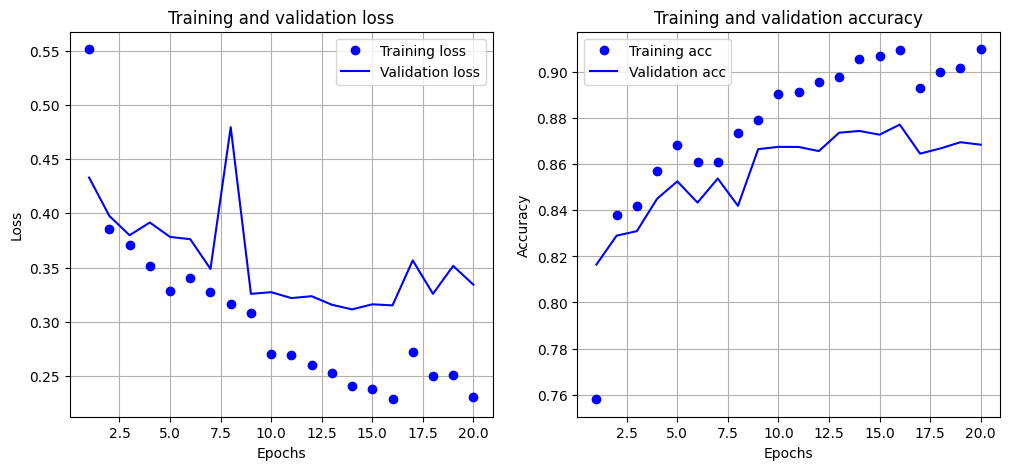

In [ ]:
# Обучение и оценка
cg_model = build_model()
final_history = custom_train_cg(cg_model, train_dataset, val_dataset, epochs=20)

# Оценка на тесте
test_loss = tf.keras.metrics.Mean()
test_acc = tf.keras.metrics.BinaryAccuracy()
for x_batch_test, y_batch_test in test_dataset:
    y_batch_test = tf.expand_dims(y_batch_test, axis=-1)
    test_logits = cg_model(x_batch_test, training=False)
    test_loss(tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_batch_test, test_logits)))
    test_acc(y_batch_test, test_logits)

print(f"\nТестовая потеря: {test_loss.result().numpy():.4f}, Тестовая точность: {test_acc.result().numpy():.4f}")

plot_history(final_history)

#### 6. Сравнительный анализ и выводы

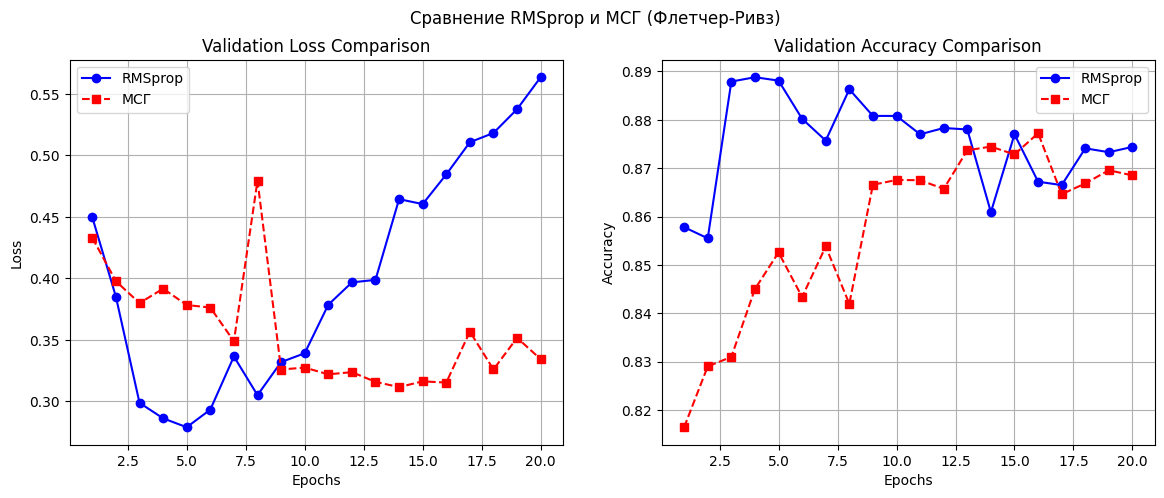

In [78]:
def plot_comparison(baseline_hist, cg_hist):
    """Функция для построения сравнительных графиков потерь и точности."""
    epochs = range(1, 21)
    plt.figure(figsize=(14, 5))
    
    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epochs, baseline_hist.history['val_loss'], 'b-o', label='RMSprop')
    plt.plot(epochs, cg_hist['val_loss'], 'r--s', label='МСГ')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epochs, baseline_hist.history['val_accuracy'], 'b-o', label='RMSprop')
    plt.plot(epochs, cg_hist['val_accuracy'], 'r--s', label='МСГ')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.suptitle('Сравнение RMSprop и МСГ (Флетчер-Ривз)')
    plt.show()

plot_comparison(baseline_history,   final_history)